In [1]:
from locationutil import *

In [2]:
%matplotlib inline

In [3]:
from copy import deepcopy
from collections import Counter
from math import radians, cos, sin, asin, sqrt
from IPython.display import display
from scipy.spatial.distance import pdist
from geopy.distance import vincenty

In [4]:
class Userdata:

    def __init__(self, uid, df, nodes, time_th, dist_th, rare_point_th, geohash_prc, trav_dist_th=50000):
        self.uid = uid
        self.df = df.copy()
        self.nodes = deepcopy(nodes)
        self.dist_th = dist_th
        self.time_th = time_th
        self.rare_point_th = rare_point_th
        self.geohash_prc = geohash_prc
        self.daily_data = []
        self.home = approx_home_location(df)
        self.motifs = []
        self.ploted_motifs = None
        self.trav_dist_th = trav_dist_th
        self.num_visited_location = []
        
        # stay point and stay region
        x = df.ix[:,['latitude','longitude','stay_point']]
        g = x.groupby('stay_point')
        self.stay_points = {}
        for name,group in g:
            pid = int(name)
            cg = group.dropna()
            c = get_geo_center(cg, lat_c='latitude', lon_c='longitude')
            self.stay_points[pid] = (c['latitude'],c['longitude'])
        
        self.stay_region = {}
        s = np.unique(df.stay_region.dropna().tolist()).tolist()
        for p in s:
            self.stay_region[p] = geohash.decode(p)
        
        # slice data into daily_data 
        for n in nodes:
            t_start = n[0]
            t_end = t_start + pd.to_timedelta('1D')
            df_s = df.loc[(df.index >= t_start) & (df.index <t_end)]
            self.daily_data.append(DailyData(self, t_start, n[1], df_s))
        
    def plot_daily_visited_locations(self, ax=None):
        return plot_daily_visited_locations(self.motifs, ax)
    
    def get_date(self, date):
        """
        Get the data for one specific date. Return None if data does not exist. 
        """
        for d in self.daily_data:
            if date==d.date:
                return d
        return None
        
        
    
    def reset(self):
        for d in self.daily_data:
            d.reset()
    
    def insert_home(self):
        for d in self.daily_data:
            d.insert_home(self.home)
    
    def sort_motif_by_freq(self):
        self.motifs.sort(key=lambda x:len(x['data']), reverse=True)
        
    def sort_motif_by_nodes(self):
        self.motifs.sort(key=lambda x:len(x['graph'].nodes()))
    
    def generate_motifs(self, inst_home=True, round_trip=True, 
                       dayofweek=[0,1,2,3,4], trav_dist_th=50000, valid_timeslot_th=8):
        """
        Generate motifs.
        
        Parameters:
        -----------
        inst_home: bool
            whether to insert home location
        """
        
        self.motifs = [] 
        
        for d in self.daily_data:
            
            # generate motifs
            m = d.generate_motif(round_trip=round_trip, insert_home=inst_home, 
                                 dayofweek=dayofweek, trav_dist_th=trav_dist_th, 
                                 valid_timeslot_th=valid_timeslot_th)
                
            # check equality of motifs
            if m is not None:
                
                found = False
                
                for item in self.motifs:
                    if nx.is_isomorphic(item['graph'],m):
                        item['data'].append(d)
                        found = True
                        break
                        
                if not found:
                    self.motifs.append({'graph':m,'data':[d]})
                    
        # sort motifs by frequency
        self.sort_motif_by_freq()
    
    def plot_all_motifs(self):
        num_motif = len(self.motifs)
        if num_motif > 0:
            self.sort_motif_by_freq()
            fig = plt.figure(figsize=(2*num_motif, 2))
            p = 1
            for item in self.motifs:
                g = item['graph']
                ax = fig.add_subplot(1,num_motif,p)
                nx.draw_spectral(g, ax=ax, node_size=10)
                p += 1
            return fig
        else:
            return None
        
        
    def plot_motifs(self):
        """
        Plot 20 most frequent motifs sorted by number of nodes.
        """
        num_motif = len(self.motifs)
        if num_motif > 0:
            self.sort_motif_by_freq()
            motifs = deepcopy(self.motifs)
            motifs = motifs[:20]
            motifs = sort_motif_by_nodes(motifs)
            self.ploted_motifs = motifs
            
            fig = plt.figure(figsize=(20, 5))
            ax = fig.add_subplot(1,1,1)
            ax = plot_motifs(ax, motifs)
            return fig
        else:
            return None
        
    def get_motif(self, idx):
        if (self.ploted_motifs is None) or (idx > len(self.motifs)):
            print(self.ploted_motifs)
            print(len(self.motifs), idx)
            return None
        else:
            return self.ploted_motifs[idx-1]
            
    def export_motifs(self):
        if len(self.motifs) > 0:
            exp_m = []
            info_prefix = {'id':self.uid, 
                           'time_th':self.time_th, 
                           'dist_th':self.dist_th, 
                           'geohash_prc':self.geohash_prc, 
                           'rare_point_th':self.rare_point_th}
            for m in self.motifs:
                m_temp = {'graph':m['graph'].copy()}
                m_temp['data'] = []
                for d in m['data']:
                    info_t = info_prefix.copy()
                    info_t['date'] = str(d.date)
                    m_temp['data'].append(info_t)
                exp_m.append(m_temp)
            return exp_m
        else:
            return None
        
    def plot_stay_points(self):
        
        map1 = folium.Map(location = geohash.decode(self.home))
        for p in self.stay_points.values():
#             folium.Marker(location = p, icon = folium.Icon(color = 'blue',icon = 'info-sign')).add_to(map1)
            folium.CircleMarker(p, radius=self.dist_th/2, color='blue', fill_color='blue').add_to(map1)
        for p in self.stay_region.values():
            folium.Marker(location=p, icon=folium.Icon(color='red',icon='info-sign')).add_to(map1)
#         map1.save('{}-stay-point.html'.format(self.uid))
        return map1
        

In [5]:
def sort_motif_by_freq(motifs):
    m = deepcopy(motifs)
    m.sort(key=lambda x:len(x['data']), reverse=True)
    return m

In [6]:
def sort_motif_by_nodes(motifs):
    m = deepcopy(motifs)
    m.sort(key=lambda x:len(x['graph'].nodes()))
    return m

In [7]:
class DailyData:
    
    def __init__(self, parent, timestp, nodes, raw_data):
        """
        Constructor
        
        Parameters:
        -----------
        timestp: timestamp
            start of the day
        nodes: list of DataFrame
            nodes information
        raw_data: DataFrame
            raw location data
        """
        self.parent = parent
        self.date = timestp.date()
        self.start_time = timestp
        self.nodes = deepcopy(nodes)
        self.nodes_bk = self.nodes.node.tolist()[0]
        self.raw_data = raw_data.copy()
        self.motif = None
        locs = np.unique(self.nodes.node.dropna().tolist())
        locs = [geohash.decode(x) for x in locs]
        if len(locs)>0:
            self.dist_matrix = pdist(locs, lambda x,y: vincenty(x,y).meters)
        else:
            self.dist_matrix = []
        
    def reset(self):
        """
        Reset nodes inforamtion (remove home location if inserted).
        Reset self.motif to None.
        """
        self.nodes.ix[0,'node'] = self.nodes_bk
        self.motif = None
    
    def get_daily_visited_location(self):
        """
        Return two daily vidisted location count: one from raw data and one from daily nodes
        """
        from_raw_data = len(self.raw_data.stay_region.tolist())
        from_daily_nodes = len(self.nodes)
        return len(self.nodes.dropna())
    
    def generate_motif(self, round_trip=True, insert_home=True, 
                   dayofweek=[0,1,2,3,4], trav_dist_th=None, valid_timeslot_th=8):
        """
        Return daily motif. Return None if this day's data is ignored.
        
        Parameters:
        -----------
        
        Returns:
        --------
        motifs: list of dictionaries
        
        num_visited: int
        """
        self.reset()
        
        
        if self.date.weekday() not in dayofweek:
            return None
        
        list_nodes = self.nodes.node.dropna().tolist()
        
        # only continue if there are enough valid time slots
        if len(list_nodes) <= valid_timeslot_th:
            return None
        
        # check if contains abnormal travel distance
        if len(self.dist_matrix)>0 and (max(self.dist_matrix) > trav_dist_th):
            return None
        
        # insert home
        if insert_home and (type(self.nodes.ix[0,'node']) is not str):
            list_nodes.insert(0,self.parent.home)
            
        # check if the day starts and ends at the same day
        if round_trip and (list_nodes[0] != list_nodes[-1]):
            return None
    
        # generate motifs
        g = nx.DiGraph()
        g.add_nodes_from(list_nodes)
        for i in range(1,len(list_nodes)):
            if list_nodes[i] != list_nodes[i-1]:
                g.add_edge(list_nodes[i-1],list_nodes[i])
        self.motif = nx.freeze(g)
        return self.motif
    
    def plot_motif(self):
        if self.motif is not None:
            fig = plt.figure(figsize=(2, 2))
            ax = fig.add_subplot(1,1,1)
            nx.draw_spectral(self.motif, ax=ax, node_size=30)
            return fig
        else:
            return None
    
    def has_long_trip(self, trav_dist_th=None):
        if trav_dist_th is None:
            trav_dist_th = self.parent.trav_dist_th
        return len(self.dist_matrix)>0 and (max(self.dist_matrix) > trav_dist_th)
    
    def draw_traj(self):
        """
        Display mobility data on a map. Blue lines are constructed from raw data. Red lines are processed data.
        """
        # draw raw location data in blue lines
        locs = self.raw_data.ix[:,['latitude','longitude']].as_matrix()
        locs = [tuple(x) for x in locs]
        
        m1 = folium.Map(location = locs[0])
        folium.PolyLine(locs, color="blue", weight=3, opacity=0.9).add_to(m1)
        
        for i in range(len(locs)):
            hour = self.raw_data.index[i].hour
            minute = self.raw_data.index[i].minute
            timestr = "{}:{}".format(hour, minute)
            folium.CircleMarker(location=locs[i], radius=5, 
                               color ='yellow', fill_color='yellow', popup=timestr).add_to(m1)
        
        # plot stay points/region
        sp_id = np.unique(self.raw_data.stay_point.dropna().apply(int).tolist())
        sp_p = [self.parent.stay_points[i] for i in sp_id]
        sr_geohash = np.unique(self.raw_data.stay_region.dropna().tolist())
        sr_p = [self.parent.stay_region[i] for i in sr_geohash]
        # plot stay point
        for p in sp_p:
            folium.CircleMarker(location=p, radius=self.parent.dist_th/2, color ='green', fill_color='green').add_to(m1)
        # plot the bonding box of each stay region
        # for p in sr_p:
        #     folium.Marker(location=p, icon=folium.Icon(color='red',icon='info-sign')).add_to(m1)
        for p in sr_geohash:
            grids = geohash.neighbors(p)
            grids.append(p)
            grid_box = [geohash.bbox(u) for u in grids]
            box_df = pd.DataFrame(grid_box)
            e = max(box_df.e)
            n = max(box_df.n)
            s = min(box_df.s)
            w = min(box_df.w)
            sw = (w,s)
            se = (e,s)
            ne = (e,n)
            nw = (w,n)
            gj = folium.GeoJson({ "type": "Polygon", "coordinates": [[sw,se,ne,nw]]})
            gj.add_children(folium.Popup("Stay region"))
            gj.add_to(m1)
        
        # draw motif data in red lines
        if self.motif is not None:
            edges = self.motif.edges()
            locs2 = []
            for e in edges:
                locs2.append(geohash.decode(e[0]))
                locs2.append(geohash.decode(e[1]))
            folium.PolyLine(locs2, color="red", weight=5, opacity=0.9).add_to(m1)
            # plot start and end location
            locs2 = self.raw_data.ix[:,'stay_point'].dropna().tolist()
            if type(self.nodes.ix[0,'node']) is not str:
                start_loc = geohash.decode(self.parent.home)
            else:
                start_loc = geohash.decode(self.nodes.ix[0,'node'])
            folium.Marker(location=start_loc, popup='Start', icon=folium.Icon(color='blue')).add_to(m1)
            folium.Marker(location=self.parent.stay_points[locs2[-1]], popup='End', icon=folium.Icon(color='blue')).add_to(m1)

        # plot home location
        folium.Marker(location=geohash.decode(self.parent.home), popup='Home', icon=folium.Icon(color='red'))
            
            
            
        # plot time
        for i in range(len(locs)):
            hour = self.raw_data.index[i].hour
            minute = self.raw_data.index[i].minute
            timestr = "{}:{}".format(hour, minute)
            folium.CircleMarker(location=locs[i], radius=5, 
                               color ='yellow', fill_color='yellow', popup=timestr).add_to(m1)
            
        
        saved_file_name = '{}-{}.html'.format(self.parent.uid, str(self.date))
        m1.save(saved_file_name)
        return m1, saved_file_name
        
    

In [8]:
def plot_motifs(ax, motifs):
    # sort motifs according to number of nodes
    c = 0
    # w = 1 / len(motifs)
    w = 1/20
    b_w = w * 0.4
    bar_pos_diff = (w - b_w) / 2
    sum_i = 0
    for m in motifs:
        sum_i += len(m['data'])
    index = 0
    for m in motifs:
        subpos = [w*(index),0.8,w,0.2]
        subax = add_subplot_axes(ax,subpos)
        nx.draw_spectral(m['graph'], ax=subax, node_size=20)
        p = patches.Rectangle((w*(index) + bar_pos_diff,0),b_w,len(m['data'])/sum_i)
        ax.add_patch(p)
        index += 1
    num_motifs = len(motifs)
    ticks = range(num_motifs)
    ticks = [w/2 + t*w for t in ticks]
    ax.set_xticks(ticks)
    ax.set_xticklabels(range(1,num_motifs+1))
    ax.set_yticks(np.linspace(0,1,11))
    return ax

In [9]:
def plot_motifs2(motifs, ax=None):
    num_motif = len(motifs)
    if ax is None:
        if num_motif > 0:
            motifs = sort_motif_by_freq(motifs)
            motifs = motifs[:20]
            motifs = sort_motif_by_nodes(motifs)

            fig = plt.figure(figsize=(20, 5))
            ax = fig.add_subplot(1,1,1)
            ax = plot_motifs(ax, motifs)
            return fig
        else:
            return None
    else:
        if num_motif > 0:
            motifs = sort_motif_by_freq(motifs)
            motifs = motifs[:20]
            motifs = sort_motif_by_nodes(motifs)
            
            ax = plot_motifs(ax, motifs)
            return ax
        else:
            return None

In [10]:
def add_motifs(motifs, new_motifs):
    """
    Check equality of motifs returned by Userdata.export_motifs().
    Add motifs from new_motifs to moitfs and return motifs.
    """
    for nm in new_motifs:
        found = False
        for m in motifs:
            if nx.is_isomorphic(m['graph'], nm['graph']):
                m['data'].extend(nm['data'])
                found = True
                break
        if not found:
            motifs.append(nm)
    return motifs

In [11]:
def generate_motif(df, nodes, round_trip=True, insert_home=True, 
                   dayofweek=[0,1,2,3,4], trav_dist_th=50000, valid_timeslot_th=8):
    """
    Generate moitfs for given data.
    
    Parameters:
    -----------
    df: DataFrame
        location data
    nodes: tuple
        nodes generated by generate_daily_nodes()
    round_trip: bool
        whether to consider only days that start and end at the same date
    insert_home: bool
        whether to insert home location if the first timeslot of daily data is missing
    dayofweek: list of integers
        which days of week to consider, [0,1,2,3,4,5,6] for Mon, Tue, Thurs, Wed, Fri, Sat, and Sun
    trav_dist_th: int
        travel distance threshold
    valid_timeslot_th: int
        valid time slot thresold required to compute daily motifs
        
    Returns:
    --------
    motifs: list of dictionary
        list of motifs, key is the graph, data is the list of timestamp for days of the same graph
        
    """
    df2 = df.copy()
    df2 = get_dayofweek(df2, dayofweek)
    if insert_home:
        home = approx_home_location(df2)
    motifs = []
    
    for n in nodes:
        tsp = n[0]
        list_nodes = n[1].node.dropna().tolist()
        
        # check day of week
        if n[0].dayofweek not in dayofweek:
            continue
        
        # check number of valid time slots
        if len(list_nodes) <= valid_timeslot_th:
            continue
        
        # fiter out days with abnormal travel distance
        un = np.unique(list_nodes)
        un = [geohash.decode(x) for x in un]
        d = pdist(un, lambda x,y: vincenty(x,y).meters)
        if len(d)>0 and (max(d) > trav_dist_th):
            continue
        
        # insert home location is necessary
        if insert_home and (type(n[1].ix[0,'node']) is not str):
            list_nodes.insert(0,home)
        
        # check whether the day is a round trip if specified
        if round_trip and (list_nodes[0] != list_nodes[-1]):
            continue
        
        # generate graph
        g = nx.DiGraph()
        g.add_nodes_from(list_nodes)
        for i in range(1,len(list_nodes)):
            if list_nodes[i] != list_nodes[i-1]:
                g.add_edge(list_nodes[i-1], list_nodes[i])
        g = nx.freeze(g)
        
        # check graph equality
        found = False
        for item in motifs:
            if nx.is_isomorphic(item['graph'], g):
                item['data'].append(tsp)
                found = True
                break
        if not found:
            motifs.append({'graph':g, 'data':[tsp]})
    return motifs

In [12]:
def plot_daily_visited_locations(motifs, ax=None):
    distr = {}
    for m in motifs:
        num_visited = len(m['graph'].nodes())
        c = len(m['data'])
        if num_visited in distr:
            distr[num_visited] += c
        else:
            distr[num_visited] = c
                
    if ax is None:
        fig = plt.figure(figsize=(5,3))
        ax = fig.add_subplot(1,1,1)
                
        nbarx = list(distr.keys())
        nbarx.sort()
        s = sum(distr.values())
        m = sum(distr.keys())
        nbary = [distr[x]/s for x in nbarx]
        ind = np.arange(len(nbarx))  # the x locations for the groups
        width = 0.2     # the width of the bars
        rects1 = ax.bar(ind, nbary, width, color='b')
        ax.set_xticks(ind+width/2)
        ax.set_xticklabels(nbarx)
        ax.set_yticks(np.linspace(0,1,11))
        return fig
    else:
        nbarx = list(distr.keys())
        nbarx.sort()
        s = sum(distr.values())
        m = sum(distr.keys())
        nbary = [distr[x]/s for x in nbarx]
        ind = np.arange(len(nbarx))  # the x locations for the groups
        width = 0.2     # the width of the bars
        rects1 = ax.bar(ind, nbary, width, color='b')
        ax.set_xticks(ind+width/2)
        ax.set_xticklabels(nbarx)
        ax.set_yticks(np.linspace(0,1,11))
        return ax

In [13]:
def get_dayofweek(df, dayofweek):
    """
    Return the day of week specified.
    
    Parameters:
    -----------
    
    df: Dataframe
        user location data
        
    Return:
    -------
    
    Dataframe
        user location data for weekdays
    """
    df2 = df.copy()
    df2['dayofweek'] = [x.dayofweek for x in df.index]
    return df2.loc[df2['dayofweek'].isin(dayofweek)]

In [176]:
uid = 'u016.csv'
time_th = '30m'
dist_th = 300
geohash_prc = 8
rare_point_th = 0.5

df, nodes = from_csv(uid, time_th, dist_th, geohash_prc, rare_point_th)

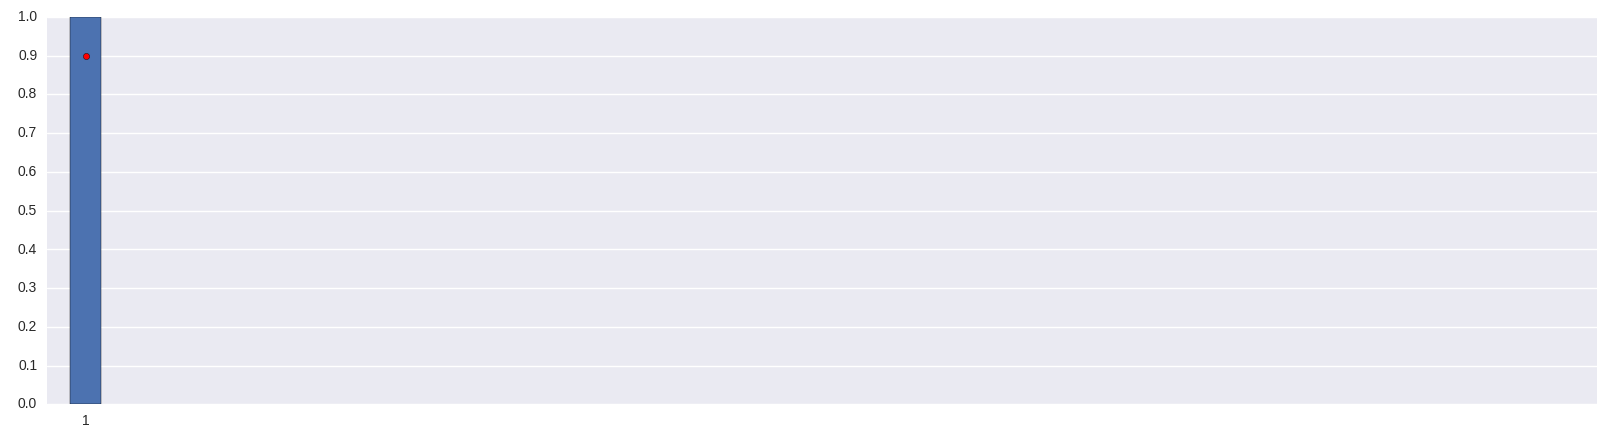

In [194]:
u = Userdata(uid=uid, df=df, nodes=nodes, time_th=time_th, rare_point_th=rare_point_th, dist_th=dist_th, geohash_prc=8)
u.generate_motifs(inst_home=True, round_trip=True, valid_timeslot_th=8)
p1 = u.plot_motifs()

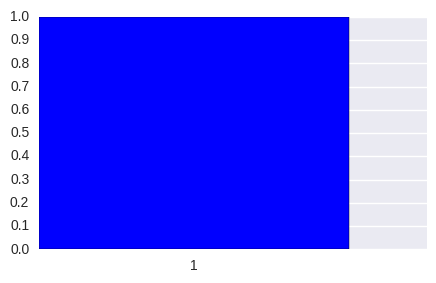

In [136]:
_ = u.plot_daily_visited_locations()

In [195]:
d = u.get_motif(1)['data'][7]
m,_ = d.draw_traj()
display(m)

In [196]:
d = u.get_motif(1)['data'][6]
m,_ = d.draw_traj()
display(m)

In [22]:
uid = 'u010.csv'
time_th = '30m'
dist_th = 300
geohash_prc = 8
rare_point_th = 0.5

df, nodes = from_csv(uid, time_th, dist_th, geohash_prc, rare_point_th)

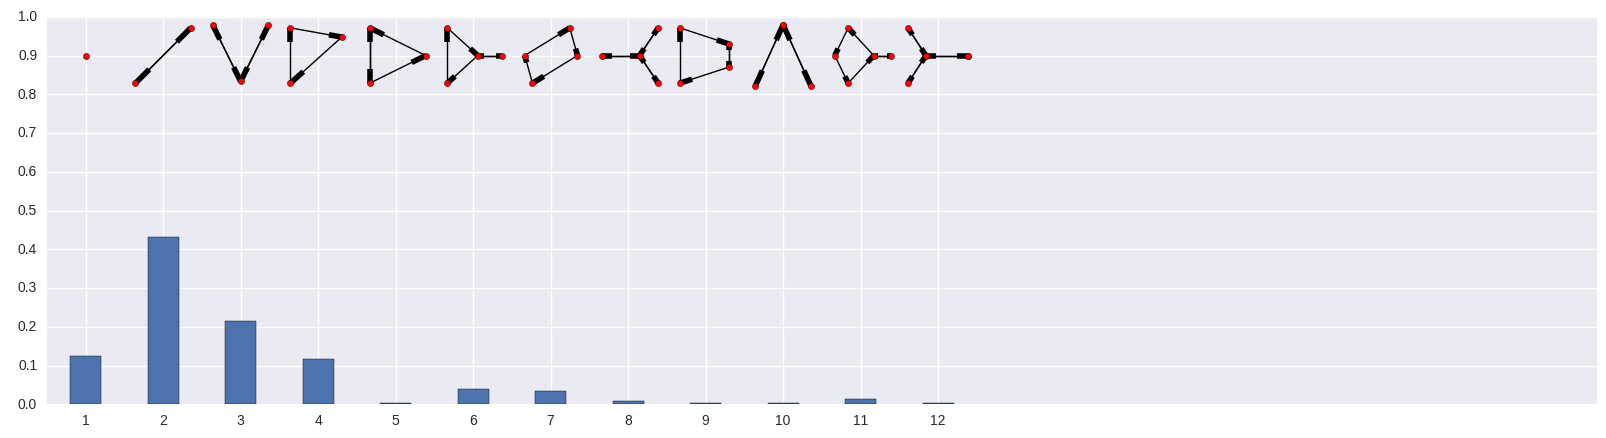

In [23]:
u = Userdata(uid=uid, df=df, nodes=nodes, time_th=time_th, rare_point_th=rare_point_th, dist_th=dist_th, geohash_prc=8)
u.generate_motifs(inst_home=True, round_trip=True, valid_timeslot_th=8)
p1 = u.plot_motifs()

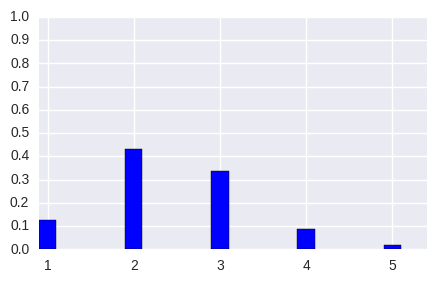

In [149]:
_ = u.plot_daily_visited_locations()

In [24]:
d = u.get_motif(1)['data'][7]
m,_ = d.draw_traj()
display(m)

In [170]:
date_t = d.date
d.date

datetime.date(2015, 7, 8)

In [171]:
uid = 'u010.csv'
time_th = '30m'
dist_th = 300
geohash_prc = 8
rare_point_th = 0

df2, nodes2 = from_csv(uid, time_th, dist_th, geohash_prc, rare_point_th)

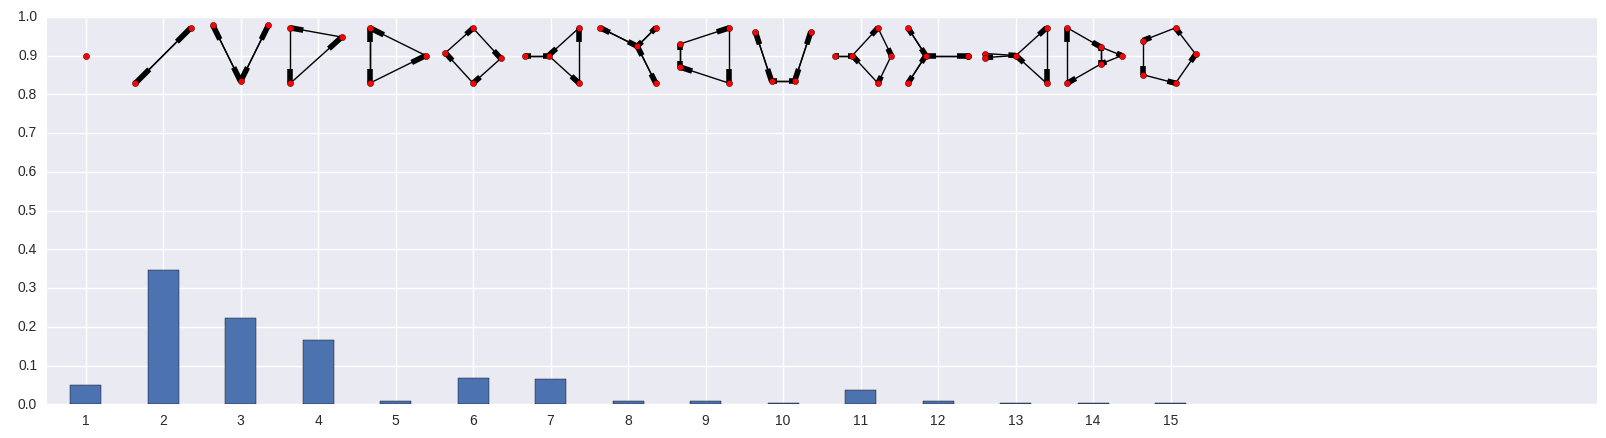

In [172]:
u = Userdata(uid=uid, df=df2, nodes=nodes2, time_th=time_th, rare_point_th=rare_point_th, dist_th=dist_th, geohash_prc=8)
u.generate_motifs(inst_home=True, round_trip=True, valid_timeslot_th=8)
p1 = u.plot_motifs()

In [173]:
date_t

datetime.date(2015, 7, 8)

In [174]:
d2 = None
for u in u.daily_data:
    if u.date == date_t:
        d2 = u
        break
print(d2)

In [175]:
m,_ = d2.draw_traj()
display(m)

In [ ]:
ll

In [ ]:
nodes[205][1]

In [ ]:
nodes[206][1]

In [23]:
motifs = generate_motif(df, nodes, round_trip=True, insert_home=True, 
                   dayofweek=[0,1,2,3,4], trav_dist_th=50000, valid_timeslot_th=8)

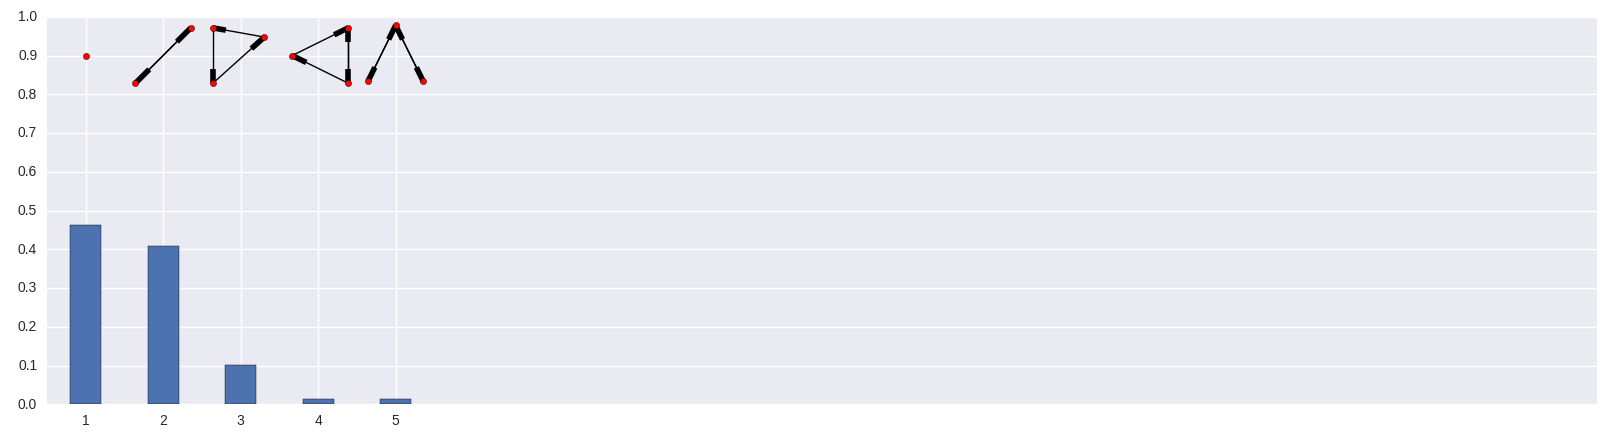

In [26]:
p2 = plot_motifs2(motifs)

In [ ]:
_ = u.plot_motifs()

In [ ]:
u.generate_motif(inst_home=False, round_trip=True, valid_timeslot_th=8)

In [ ]:
_ = u.plot_motifs()

-----------------------------------------------------------------------------------------------------------------------

In [43]:
data = ['u010.csv', 'u021.csv', 'u015.csv', 'u014.csv', 'u022.csv', 'u016.csv', 'u009.csv', 'u008.csv', 'u013.csv', 'u018.csv', 'u007.csv', 'u006.csv', 'u029.csv', 'u011.csv', 'u032.csv', 'u051.csv', 'u055.csv', 'u056.csv', 'u031.csv', 'u035.csv', 'u033.csv', 'u012.csv', 'u050.csv', 'u005.csv', 'u028.csv', 'u054.csv', 'u017.csv', 'u019.csv', 'u030.csv', 'u063.csv']

In [16]:
processed_users = data[-3:]
print(processed_users)

['u019.csv', 'u030.csv', 'u063.csv']


In [19]:
# Read from csv 
# and generate daily motifs
time_ths = ['15m','30m','45m']
dist_ths = [50,100,200,300]
rare_point_ths = [0,0.1,0.5]
geohash_prc = 8
overall_motifs = []

for time_th in time_ths:
    overall_motifs_temp1 = []
    
    for dist_th in dist_ths:
        overall_motifs_temp2 = []
        
        for rare_point_th in rare_point_ths:

            motifs = []
            for uid in processed_users:
                
                # load data from csv files
                df,nodes = from_csv(uid, time_th, dist_th, geohash_prc, rare_point_th)
                
                # generate motifs
                c_motifs = generate_motif(df, nodes, round_trip=True, insert_home=True, 
                                        dayofweek=[0,1,2,3,4], trav_dist_th=50000, valid_timeslot_th=8)
                motifs = add_motifs(motifs, c_motifs)
            
            overall_motifs_temp2.append(motifs)
        
        overall_motifs_temp1.append(overall_motifs_temp2)
    
    overall_motifs.append(overall_motifs_temp1)

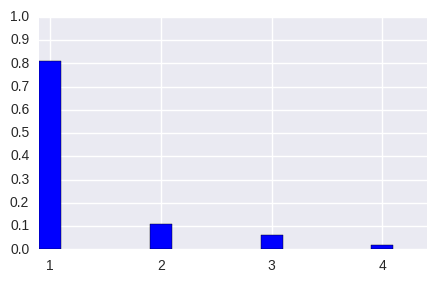

In [34]:
f = plot_daily_visited_locations(overall_motifs[0][0][0])

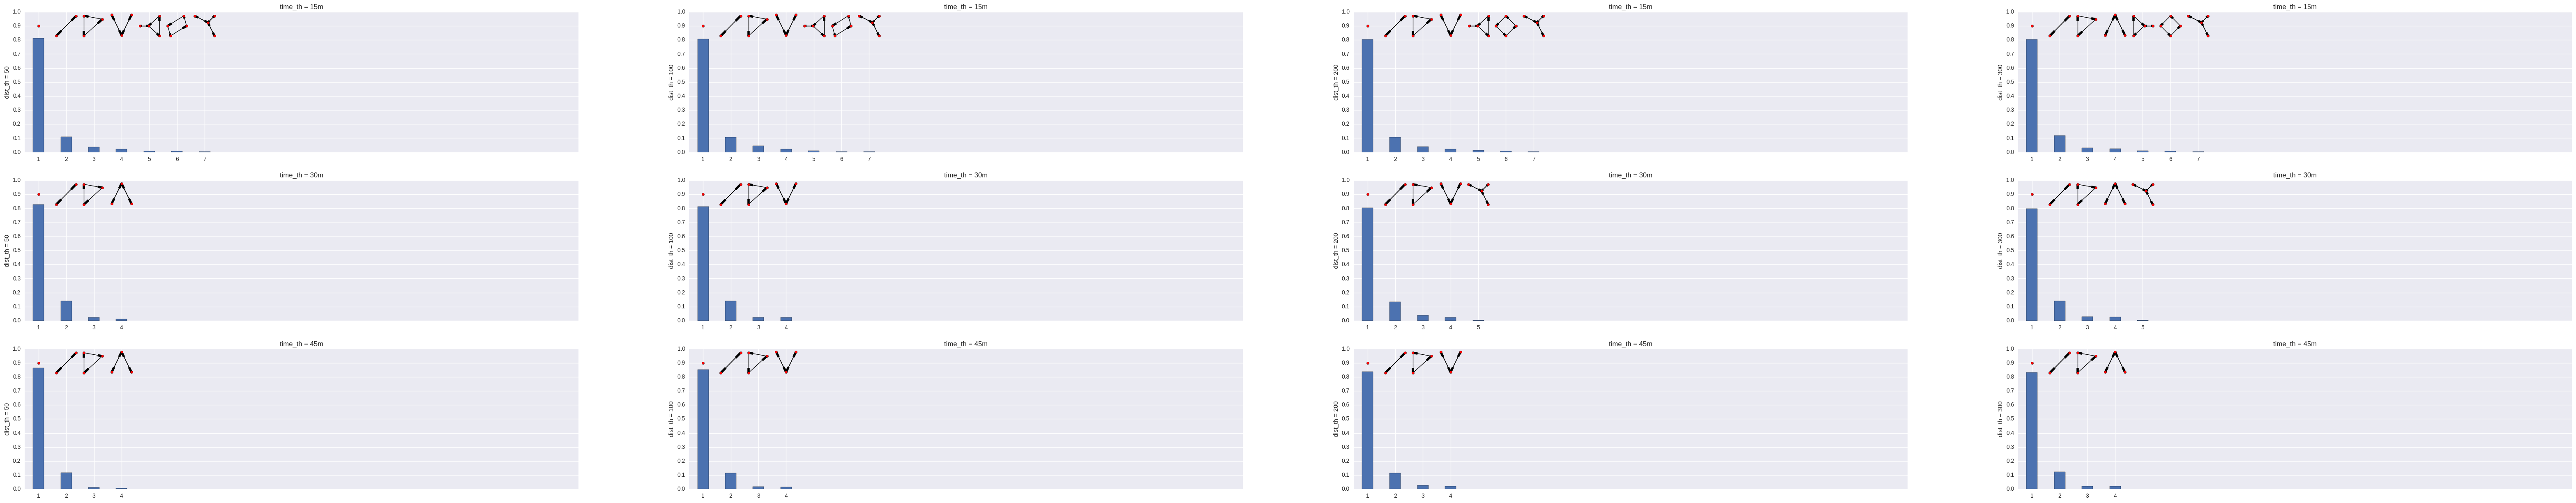

In [27]:
# plot motifs
cols = len(dist_ths)
rows = len(time_ths)
fig = plt.figure(figsize=(cols*20, rows*5))
c = 0
for i in range(rows):
    for j in range(cols):
        k = 0 # rare point theshold = 0
        c_motif = overall_motifs[i][j][k]
        c += 1
        ax = fig.add_subplot(rows,cols,c)
        ax = plot_motifs2(c_motif, ax)
        ax.set_title('time_th = {}'.format(time_ths[i]))
        ax.set_ylabel('dist_th = {}'.format(dist_ths[j],rotation = 'vertical'))


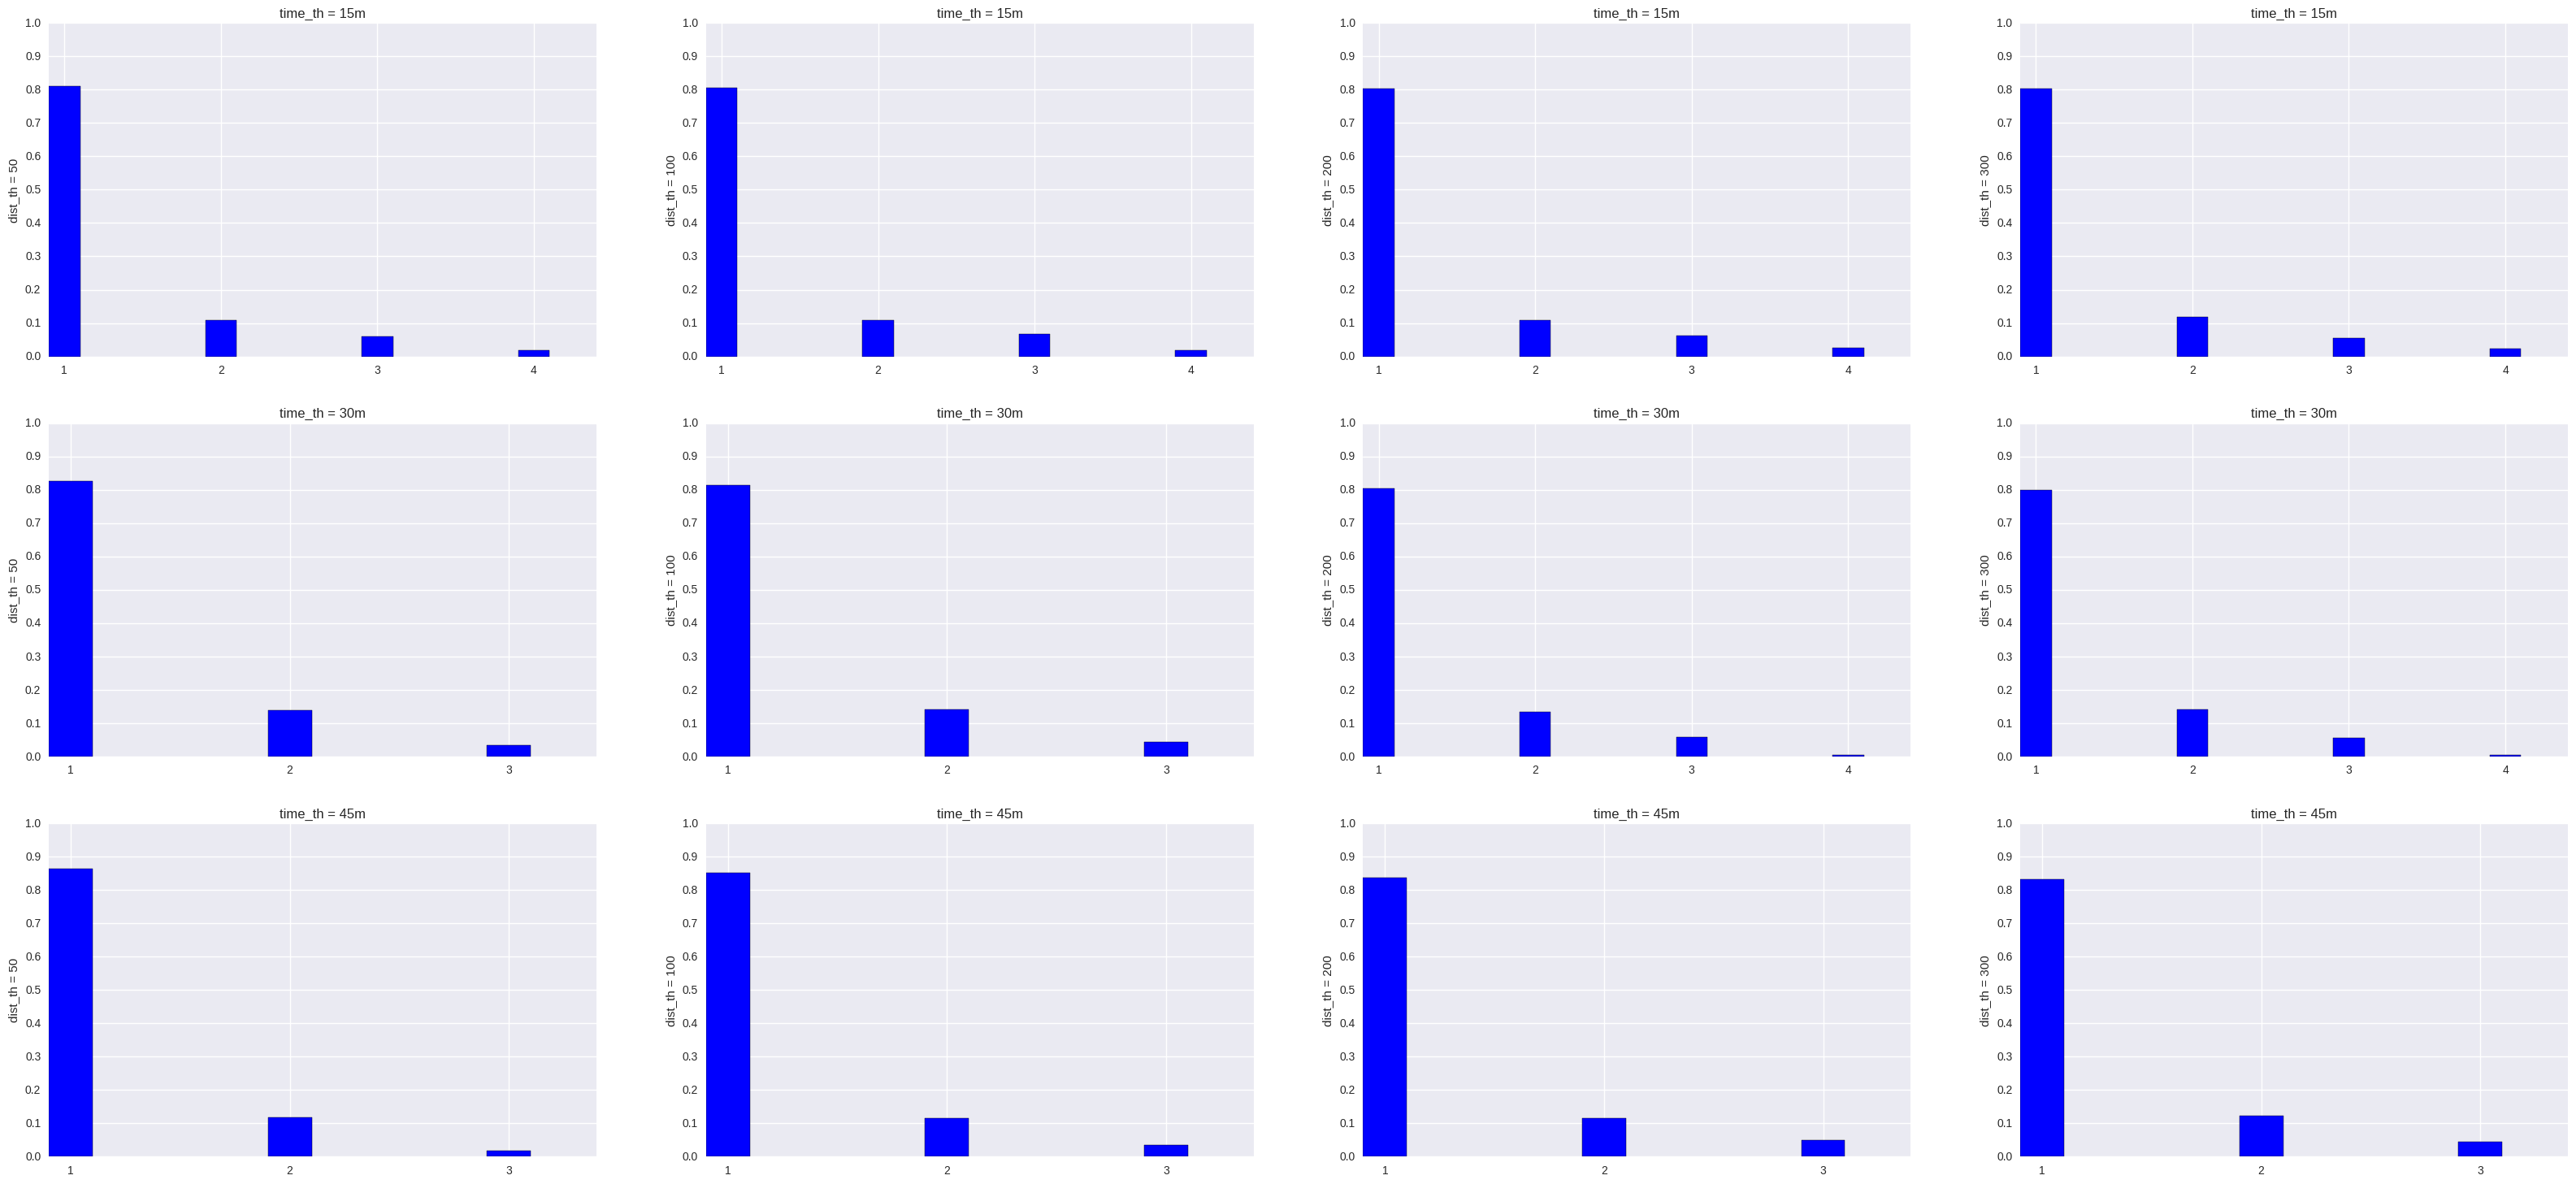

In [42]:
# plot number of visited locations
cols = len(dist_ths)
rows = len(time_ths)
fig = plt.figure(figsize=(cols*10, rows*6))
c = 0
for i in range(rows):
    for j in range(cols):
        k = 0 # rare point theshold = 0
        c += 1
        c_motif = overall_motifs[i][j][k]
        ax = fig.add_subplot(rows, cols, c)
        ax = plot_daily_visited_locations(c_motif, ax)
        ax.set_title('time_th = {}'.format(time_ths[i]))
        ax.set_ylabel('dist_th = {}'.format(dist_ths[j],rotation = 'vertical'))

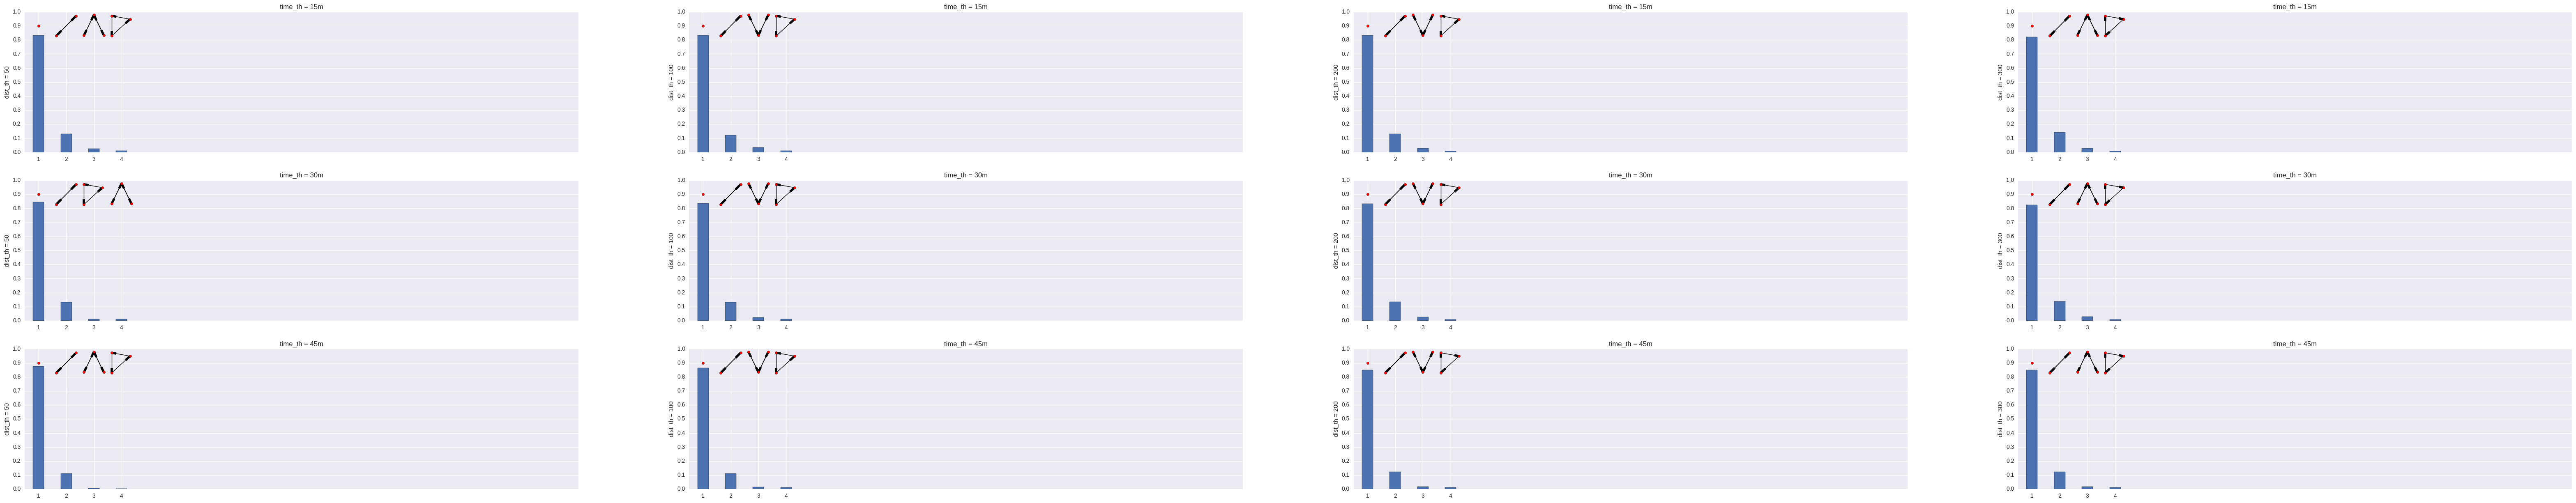

In [32]:
# plot motifs
cols = len(dist_ths)
rows = len(time_ths)
fig = plt.figure(figsize=(cols*20, rows*5))
c = 0
for i in range(rows):
    for j in range(cols):
        k = 1 # rare point theshold = 0.1
        c_motif = overall_motifs[i][j][k]
        c += 1
        ax = fig.add_subplot(rows,cols,c)
        ax = plot_motifs2(c_motif, ax)
        ax.set_title('time_th = {}'.format(time_ths[i]))
        ax.set_ylabel('dist_th = {}'.format(dist_ths[j],rotation = 'vertical'))

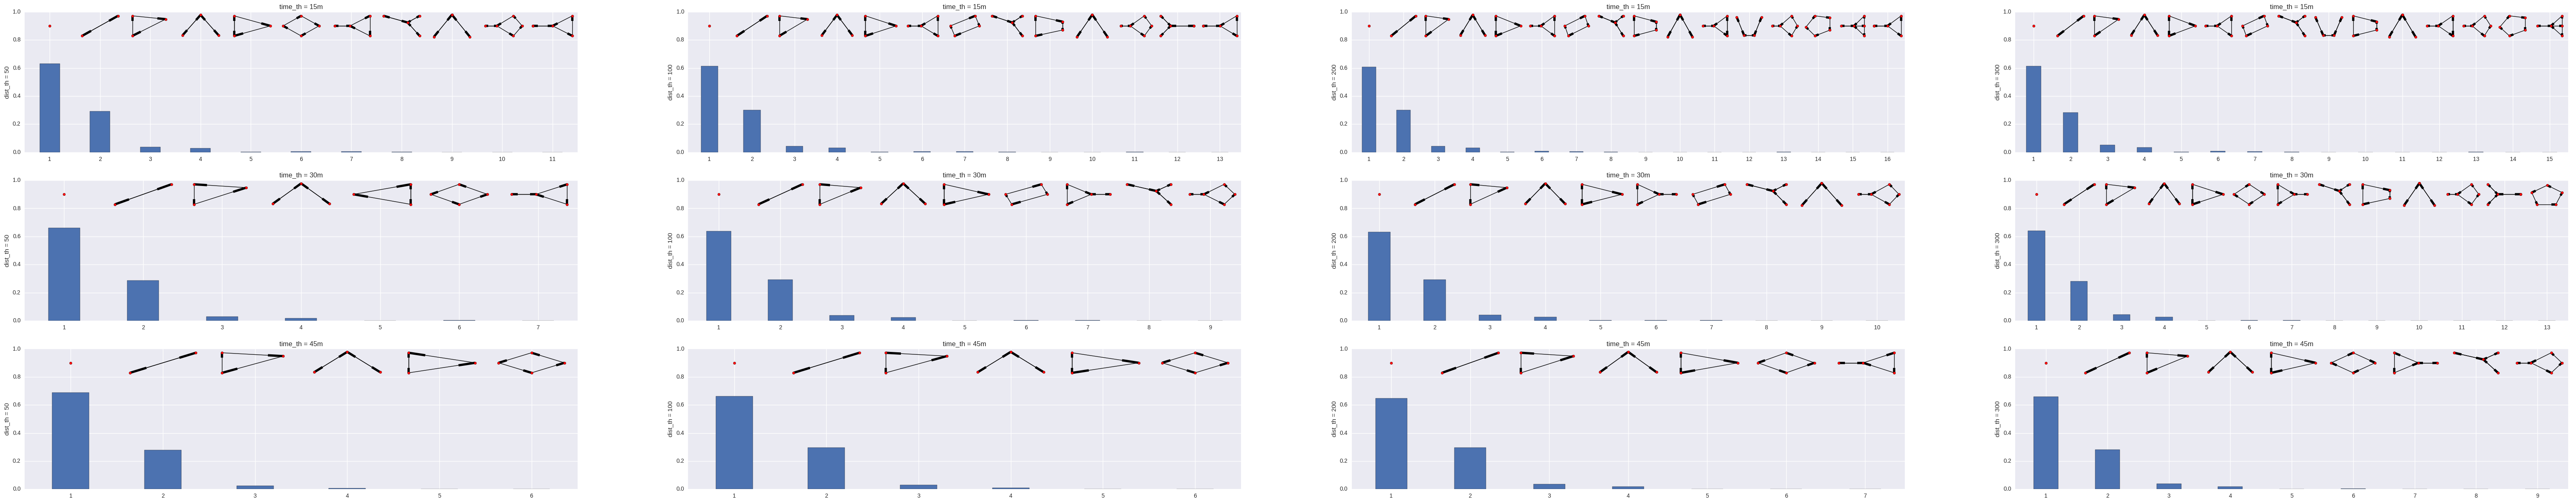

In [119]:
# plot motifs
cols = len(dist_ths)
rows = len(time_ths)
fig = plt.figure(figsize=(cols*20, rows*5))
c = 0
for i in range(rows):
    for j in range(cols):
        k = 2 # rare point theshold = 0.5
        c_motif = overall_motifs[i][j][k]
        c += 1
        ax = fig.add_subplot(rows,cols,c)
        ax = plot_motifs2(c_motif, ax)
        ax.set_title('time_th = {}'.format(time_ths[i]))
        ax.set_ylabel('dist_th = {}'.format(dist_ths[j],rotation = 'vertical'))

In [22]:
uid = 'u010.csv'
time_th = '10m'
dist_th = 300
geohash_prc = 8
rare_point_th = 0

In [23]:
df5 = read_data(uid)

In [24]:
df5['stay_point'] = get_stay_point(df5, dist_th=dist_th, time_th=time_th)
df5['stay_region'] = get_stay_region(df5)

In [26]:
# # generate daily nodes
# nodes = generate_daily_nodes(df5.dropna(subset=['stay_region']), 
#                              'stay_region',
#                              valid_day_th=8,
#                              shift_day_start=pd.to_timedelta('3H'),
#                              rare_pt_pct_th=rare_point_th)
# # save to file
# to_csv(uid, df5, nodes, time_th, dist_th, geohash_prc, rare_point_th)

In [ ]:
df5, nodes5 = from_csv(uid, time_th, dist_th, geohash_prc, rare_point_th)

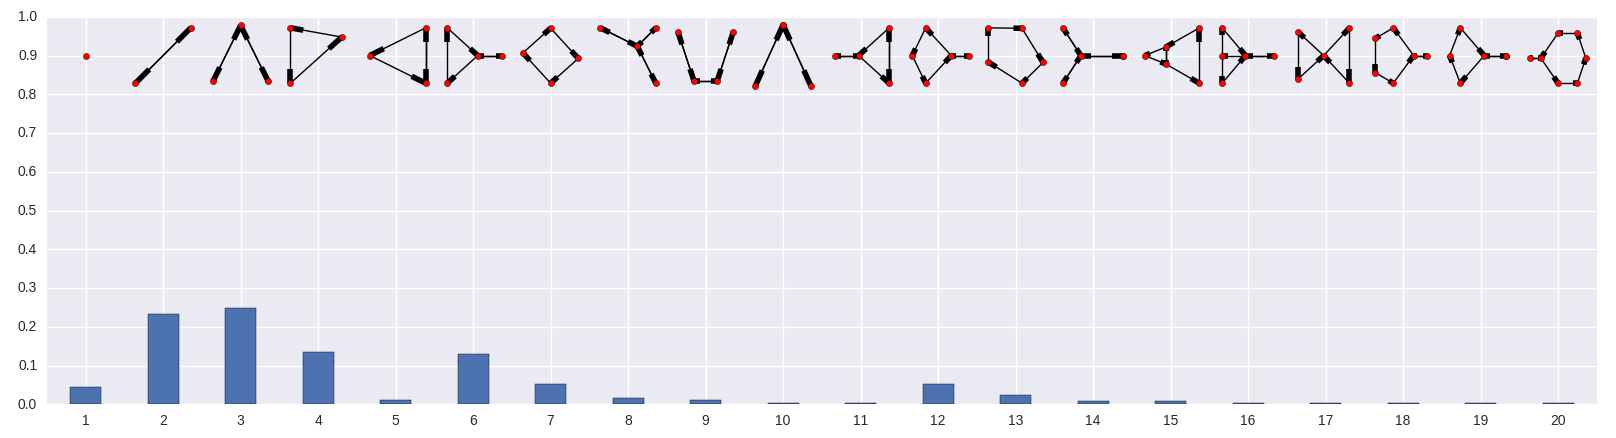

In [28]:
u5 = Userdata(uid=uid, df=df5, nodes=nodes5, time_th=time_th, rare_point_th=rare_point_th, dist_th=dist_th, geohash_prc=8)
u5.generate_motifs(inst_home=True, round_trip=True, valid_timeslot_th=8)
_ = u5.plot_motifs()

In [14]:
uid = 'u016.csv'
time_th = '10m'
dist_th = 300
geohash_prc = 8
rare_point_th = 0

In [15]:
df6 = read_data(uid)

In [16]:
df6['stay_point'] = get_stay_point(df6, dist_th=dist_th, time_th=time_th)
df6['stay_region'] = get_stay_region(df6)

In [17]:
# generate daily nodes
nodes6 = generate_daily_nodes(df6.dropna(subset=['stay_region']), 
                             'stay_region',
                             valid_day_th=8,
                             shift_day_start=pd.to_timedelta('3H'),
                             rare_pt_pct_th=rare_point_th)
# save to file
to_csv(uid, df6, nodes6, time_th, dist_th, geohash_prc, rare_point_th)

In [ ]:
# df6, nodes6 = from_csv(uid, time_th, dist_th, geohash_prc, rare_point_th)

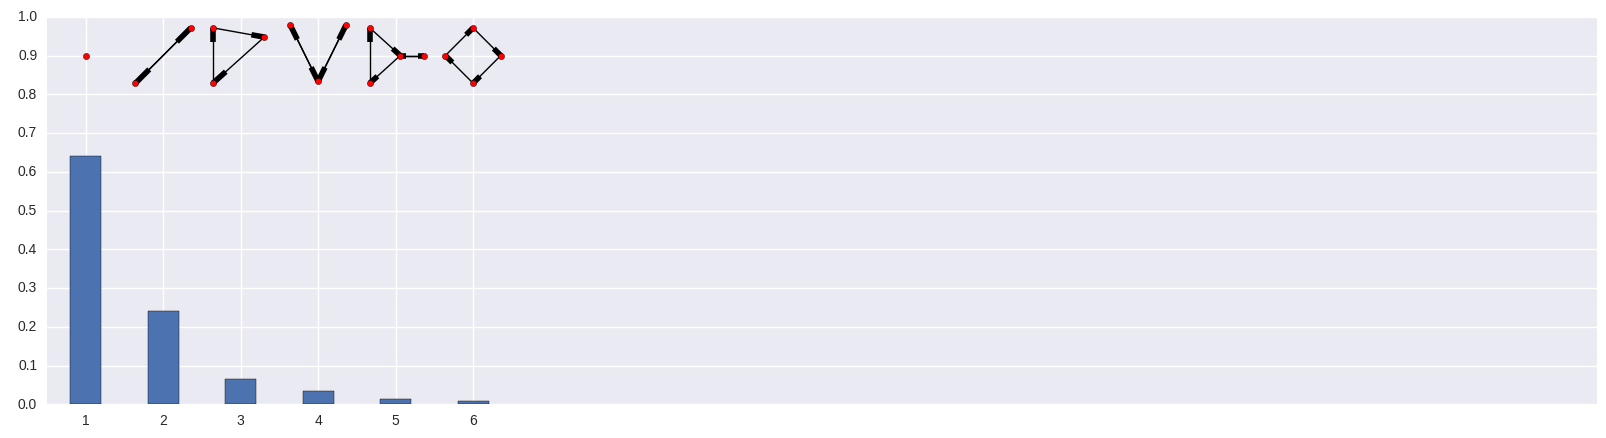

In [18]:
u6 = Userdata(uid=uid, df=df6, nodes=nodes6, time_th=time_th, rare_point_th=rare_point_th, dist_th=dist_th, geohash_prc=8)
u6.generate_motifs(inst_home=True, round_trip=True, valid_timeslot_th=8)
_ = u6.plot_motifs()

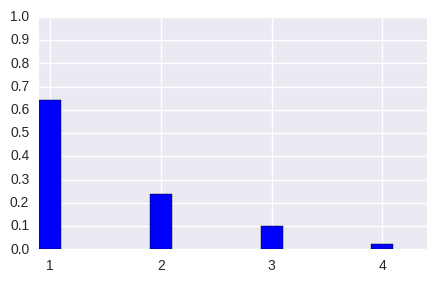

In [20]:
_ = u6.plot_daily_visited_locations()